In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D
from scipy.integrate import quad as quad
%matplotlib notebook

from astropy import constants as const
from astropy.table import Table
from astropy.io import fits
import sys
sys.path.insert(0, "/scratch/ierez/IGMCosmo/VoidFinder/python/")
import voidfinder
#from voidfinder.voidfinder_functions import xyz_to_radecz #THERE IS NO SUCH FUNCTION

In [2]:
#copy pasted from github

RtoD = 180./np.pi
DtoR = np.pi/180.
dec_offset = -90
def to_array(table):
    '''Convert table to numpy array'''

    array = np.array([table['x'], table['y'], table['z']])
    array = array.T

    return array

def xyz_to_radecz(sphere_table):
    '''
    Calculate the ra, dec coordinates for the centers of each sphere
    '''

    r = np.linalg.norm(to_array(sphere_table), axis=1)
    sphere_table['r'] = r.T
    sphere_table['ra'] = np.arctan(sphere_table['y']/sphere_table['x'])*RtoD
    sphere_table['dec'] = np.arcsin(sphere_table['z']/sphere_table['r'])*RtoD

    # Adjust ra value as necessary
    boolean = np.logical_and(sphere_table['y'] != 0, sphere_table['x'] < 0)
    sphere_table['ra'][boolean] += 180.

    return sphere_table

# Data files

### Galaxies

In [3]:
data_directory = '/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/'

# Original SDSS DR7 (KIAS-VAGC)
dr7_filename = data_directory + 'deltafields_RAadded90.fits'

# Downsampled SDSS DR7 (to match SDSS LOWZ)
#downDR7_filename = data_directory + 'kias1033_5_LOWZ.txt'

quasars_filename='/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/quasars.fits'

### Voids

In [4]:
void_directory = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/before_names_fluxcut4/'
void10_directory = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/before_names/'
# Original DR7 voids

dr7void_filename = void_directory + 'deltafields_RAadded90._comoving_holes_noMagCut.txt'
void10_filename = void10_directory + 'deltafields_RAadded90._comoving_holes_noMagCut.txt'
# Downsampled SDSS DR7 voids
#downDR7void_filename = void_directory + 'kias1033_5_LOWZ_comoving_holes.txt'

# Import data

### Galaxies

In [5]:
# Original SDSS DR7
#dr7_galaxies = Table.read(dr7_filename, 
#                          format='ascii.commented_header', 
#                          include_names=['ra', 'dec', 'redshift', 'delta'])

dr7_galaxies=fits.open(dr7_filename)  

dr7_galaxies=Table(dr7_galaxies[1].data)
dr7_galaxies
dr7_galaxies['z'].name='redshift'

quasars=fits.open(quasars_filename) 
quasars=Table(quasars[1].data)
quasars
# Downsampled SDSS DR7
#dr7LOWZ_galaxies = Table.read(downDR7_filename, 
#                              format='ascii.commented_header', 
#                              include_names=['ra', 'dec', 'redshift', 'Rgal', 'rabsmag'])

ra,dec,z
float64,float64,float64
21.652010971159942,-1.0040558414971168,2.26395440101624
21.7023149914553,-1.1940359112320433,2.2
21.531981101320415,-0.9548237196365138,2.19532799720764
21.614665018659853,-0.891022759832792,2.25147986412048
21.68371321770447,-0.7983495021364124,2.11498427391052
21.743584489532463,-0.7447240159580004,2.967
21.8362073798891,-0.7001633387061917,2.7378306388855
21.93637779576612,-0.8750650268817084,2.50433731079102
21.965753537514168,-0.5210704261630801,2.94729614257812


##### Reduce original DR7 to magnitude-limited survey

In [6]:
#mag_cut = dr7_galaxies['rabsmag'] <= -20
#z_cut = dr7_galaxies['redshift'] < 0.1026

#vollim_dr7_galaxies = dr7_galaxies[np.logical_and(mag_cut, z_cut)]
vollim_dr7_galaxies = dr7_galaxies

### Voids

In [7]:
# Original DR7 voids
dr7_voids = Table.read(dr7void_filename, format='ascii.commented_header')
voids10 = Table.read(void10_filename, format='ascii.commented_header')
# Downsampled SDSS DR7 voids
#dr7LOWZ_voids = Table.read(downDR7void_filename, format='ascii.commented_header')

##### Convert x,y,z to ra,dec,z for voids

In [8]:
dr7_voids = xyz_to_radecz(dr7_voids)
voids10 = xyz_to_radecz(voids10)
#dr7LOWZ_voids = xyz_to_radecz(dr7LOWZ_voids)

# Convert redshift to comoving distance

Going to plot $comoving distance$ in Mpch-1
At these high redshifts, cz is not meaningful. So plot for comoving distance instead.

In [9]:
c = const.c.to('km/s').value
#z to comoving
#voidfinder.distance.z_to_comoving_dist

Omega_M = 0.3147
c = const.c.to('km/s').value
def Distance(z,omega_m = Omega_M,h = 1):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

def f(a,omega_m = Omega_M):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))

quasars['r']= Distance(quasars['z'],Omega_M,1)
#Continue with voids['r']

dr7_galaxies['r']= Distance(dr7_galaxies['redshift'],Omega_M,1)
#dr7LOWZ_galaxies['cz'] = c*dr7LOWZ_galaxies['redshift']

## Check inside the tables

In [10]:
dr7_galaxies

ra,dec,redshift,delta,r
float64,float64,float64,float64,float64
111.65201097115994,-1.0040558414971168,1.9695286235943632,-0.7501514290604856,3550.8681936770345
111.65201097115994,-1.0040558414971168,1.9715806099463196,-2.9951701434370044,3552.9262687279943
111.65201097115994,-1.0040558414971168,1.9736340142499142,-8.42713942396928,3554.9837964309104
111.65201097115994,-1.0040558414971168,1.975688837484979,1.443690511787549,3557.0407766191024
111.65201097115994,-1.0040558414971168,1.9777450806320127,-4.4328915242131295,3559.0972091266394
111.65201097115994,-1.0040558414971168,1.9798027446721909,-0.7920112475562439,3561.1530937883467
111.65201097115994,-1.0040558414971168,1.9818618305873779,3.139563038718462,3563.208430439811
111.65201097115994,-1.0040558414971168,1.9839223393601022,-3.3280128864671483,3565.2632189173696
111.65201097115994,-1.0040558414971168,1.9859842719735858,-0.5576560308926432,3567.317459058115


In [11]:
dr7_voids

x,y,z,radius,flag,r,ra,dec
float64,float64,float64,float64,int64,float64,float64,float64
-1788.0611669132952,4077.013467225798,-36.829022416871005,48.20955555883913,0,4452.02851804164,113.68087805155808,-0.47397980662020844
-1790.1735722277888,4074.021531294554,-46.45579953990119,47.69865332379481,0,4450.228196111444,113.72125846543382,-0.598119798545132
-1697.0101341607037,3873.294075643735,-33.042598211027496,47.07601279570403,1,4228.87008610545,113.65971514607139,-0.44768948857866586
2721.830522849569,3520.5951085246165,38.9470286651614,47.035607663838114,2,4450.221138811516,52.29179513159049,0.5014422394856778
-1787.9424099717387,4075.1720721960323,-26.472481274620193,47.01527103319866,0,4450.220923914551,113.688999947319,-0.3408303591200206
-1685.5644767809101,3804.6101813884025,-32.92224657537143,46.3377833215246,3,4161.402421303372,113.8948805312603,-0.45329080620065737
2720.7520630808685,3516.883162254733,38.503478284698325,46.278664295287044,2,4446.6213559903745,52.27353390096588,0.49613272526742497
2715.142703133695,3509.858326343686,38.46583673033685,46.25372473520157,2,4437.632813784801,52.27531868296009,0.49665165924254234
2706.974358501175,3497.9533620833386,38.1014532680306,45.700408642421564,2,4423.215981798098,52.264652046567335,0.493550274894914


In [12]:
quasars

ra,dec,z,r
float64,float64,float64,float64
21.652010971159942,-1.0040558414971168,2.26395440101624,3827.378687379918
21.7023149914553,-1.1940359112320433,2.2,3770.3636842348196
21.531981101320415,-0.9548237196365138,2.19532799720764,3766.1357797936994
21.614665018659853,-0.891022759832792,2.25147986412048,3816.3819520123707
21.68371321770447,-0.7983495021364124,2.11498427391052,3692.043413189639
21.743584489532463,-0.7447240159580004,2.967,4364.521595040107
21.8362073798891,-0.7001633387061917,2.7378306388855,4205.473556801272
21.93637779576612,-0.8750650268817084,2.50433731079102,4028.299577585795
21.965753537514168,-0.5210704261630801,2.94729614257812,4351.373842644665


In [13]:
max(dr7_voids['ra'])

134.910254512208

In [14]:
max(quasars['ra'])

44.99658812997919

In [15]:
max(dr7_galaxies['ra'])

134.9965881299792

In [16]:
dr7_voids['ra']=dr7_voids['ra']-90
voids10['ra']=voids10['ra']-90
dr7_galaxies['ra']=dr7_galaxies['ra']-90

# Function to set up axes

Following function from declination_slice.ipynb

In [17]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    #tr_rotate = Affine2D().translate(-90, 0) #already fixed ra
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    #tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    tr = tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("Comoving Distance [Mpc/h]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

# Wedge plot

In [18]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get different slices
d,s = -1.25, 2.5 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small
slice_ = d + 0.5*s

### Remove galaxies outside declination range

In [19]:
dr7_dec_cut = np.logical_and(dr7_galaxies['dec'] > d, 
                             dr7_galaxies['dec'] <= d + s)

#dr7LOWZ_dec_cut = np.logical_and(dr7LOWZ_galaxies['dec'] > d, 
#                                 dr7LOWZ_galaxies['dec'] <= d + s)
#
vollim_dr7_dec_cut = np.logical_and(vollim_dr7_galaxies['dec'] > d, 
                                    vollim_dr7_galaxies['dec'] <= d + s)
#
dr7_dec_slice = dr7_galaxies[dr7_dec_cut]
#dr7LOWZ_dec_slice = dr7LOWZ_galaxies[dr7LOWZ_dec_cut]
vollim_dr7_dec_slice = vollim_dr7_galaxies[vollim_dr7_dec_cut]

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                             quasars['dec'] <= d + s)

quasars_slice = quasars[quasars_dec_cut]

### Remove galaxies outside distance range

In [20]:
#cz_min, cz_max = min(dr7_voids['r']), max(dr7_voids['r']) #32700
cz_min, cz_max = min(dr7_galaxies['r']), max(quasars['r'])

dr7_dist_boolean = np.logical_and(dr7_dec_slice['r'] > cz_min, 
                                  dr7_dec_slice['r'] <= cz_max)

#dr7LOWZ_dist_boolean = np.logical_and(dr7LOWZ_dec_slice['cz'] > cz_min, 
#                                      dr7LOWZ_dec_slice['cz'] <= cz_max)
#
#vollim_dr7_dist_boolean = np.logical_and(vollim_dr7_dec_slice['cz'] > cz_min, 
#                                         vollim_dr7_dec_slice['cz'] <= cz_max)
#
dr7_sample = dr7_dec_slice[dr7_dist_boolean]
#dr7LOWZ_sample = dr7LOWZ_dec_slice[dr7LOWZ_dist_boolean]
#vollim_dr7_sample = vollim_dr7_dec_slice[vollim_dr7_dist_boolean]


### Voids that intersect the slice

In [21]:
dr7_dec_intersect_cut = np.sin(np.abs(slice_ - dr7_voids['dec'])*np.pi/180)*dr7_voids['r'] <= dr7_voids['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

dr7_void_sample = dr7_voids[dr7_dec_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
dr7_void_sample['radius_intersect'] = np.sqrt(dr7_void_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - dr7_void_sample['dec'])*np.pi/180)*dr7_void_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

In [22]:
dec10_intersect_cut = np.sin(np.abs(slice_ - voids10['dec'])*np.pi/180)*voids10['r'] <= voids10['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

void10_sample = voids10[dec10_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
void10_sample['radius_intersect'] = np.sqrt(void10_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - void10_sample['dec'])*np.pi/180)*void10_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

In [23]:
min(quasars['ra'])

-42.99625309050879

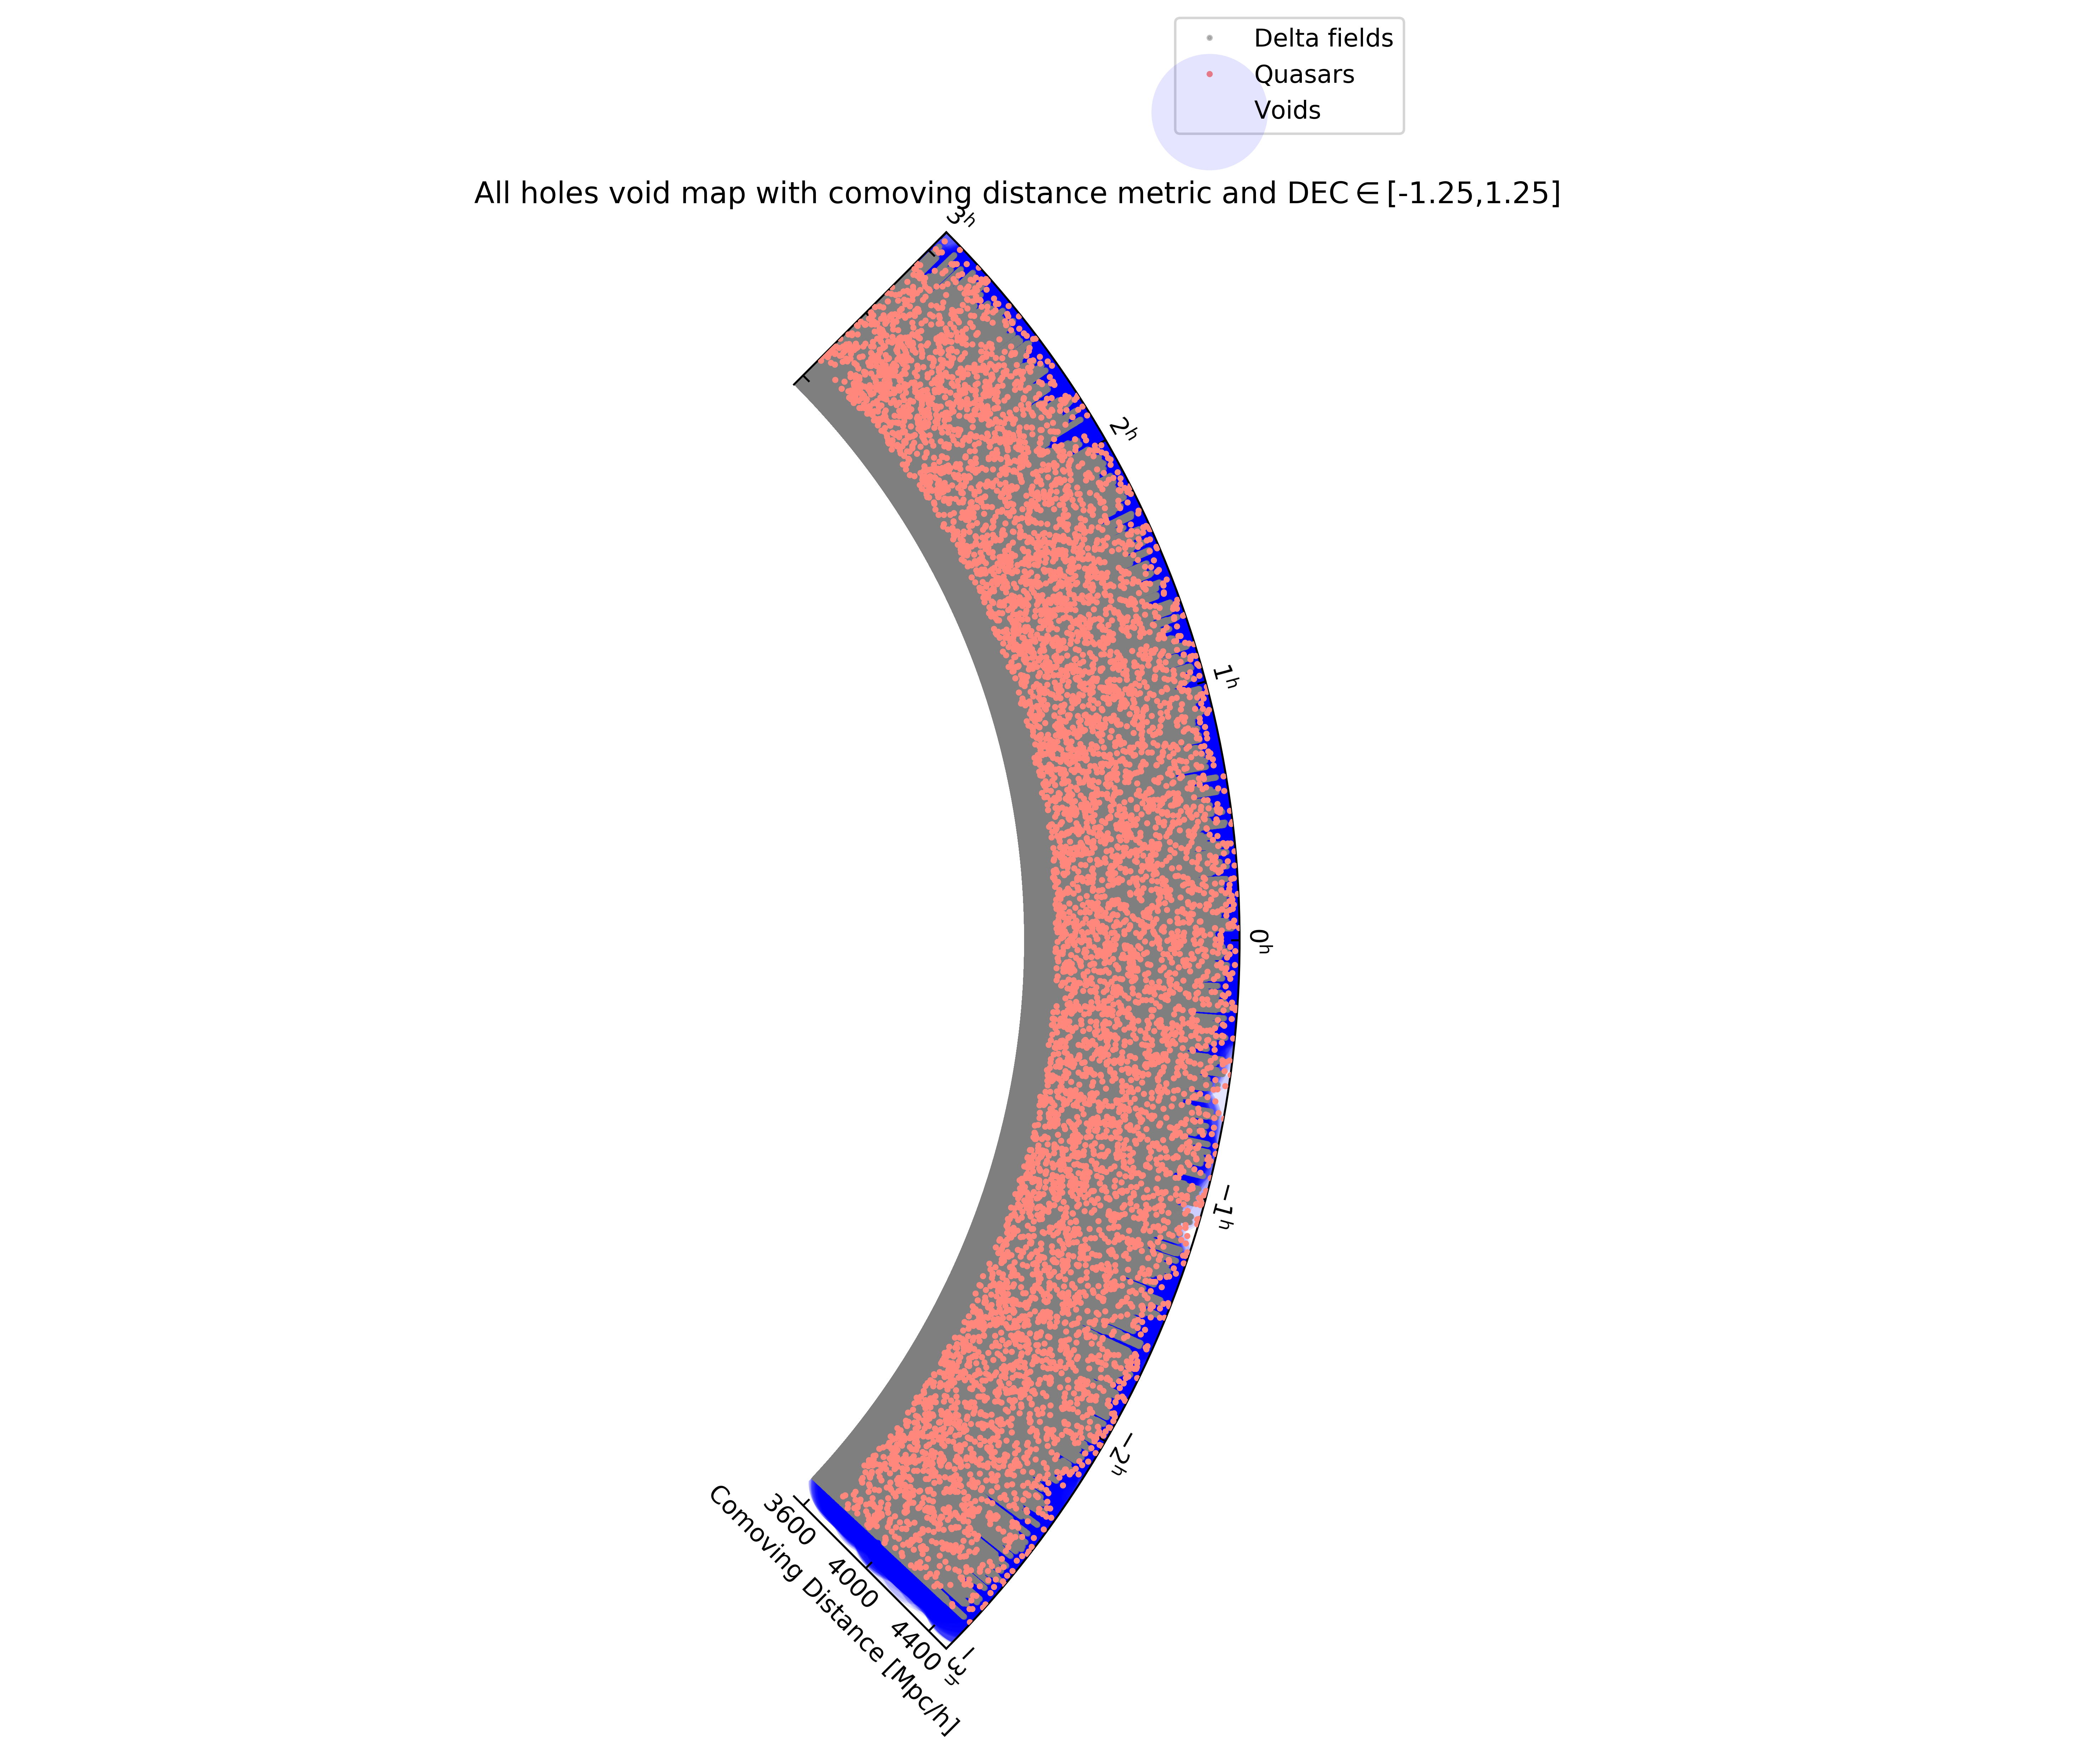

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,10))

# Range of ra to use in plot
ra_min, ra_max = -45, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars['ra'], 
            quasars['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

In [ ]:
dr7_sample

ra,dec,redshift,delta,r
float64,float64,float64,float64,float64
21.65201097115994,-1.0040558414971168,1.9695286235943632,-0.7501514290604856,3550.8681936770345
21.65201097115994,-1.0040558414971168,1.9715806099463196,-2.9951701434370044,3552.9262687279943
21.65201097115994,-1.0040558414971168,1.9736340142499142,-8.42713942396928,3554.9837964309104
21.65201097115994,-1.0040558414971168,1.975688837484979,1.443690511787549,3557.0407766191024
21.65201097115994,-1.0040558414971168,1.9777450806320127,-4.4328915242131295,3559.0972091266394
21.65201097115994,-1.0040558414971168,1.9798027446721909,-0.7920112475562439,3561.1530937883467
21.65201097115994,-1.0040558414971168,1.9818618305873779,3.139563038718462,3563.208430439811
21.65201097115994,-1.0040558414971168,1.9839223393601022,-3.3280128864671483,3565.2632189173696
21.65201097115994,-1.0040558414971168,1.9859842719735858,-0.5576560308926432,3567.317459058115


In [ ]:
dr7_void_sample

x,y,z,radius,flag,r,ra,dec,radius_intersect
float64,float64,float64,float64,int64,float64,float64,float64,float64
-1788.0611669132952,4077.013467225798,-36.829022416871005,48.20955555883913,0,4452.02851804164,23.680878051558082,-0.47397980662020844,31.10923263274762
-1790.1735722277888,4074.021531294554,-46.45579953990119,47.69865332379481,0,4450.228196111444,23.72125846543382,-0.598119798545132,10.817588363959768
-1697.0101341607037,3873.294075643735,-33.042598211027496,47.07601279570403,1,4228.87008610545,23.65971514607139,-0.44768948857866586,33.53114498799425
2721.830522849569,3520.5951085246165,38.9470286651614,47.035607663838114,2,4450.221138811516,-37.70820486840951,0.5014422394856778,26.37190449060521
-1787.9424099717387,4075.1720721960323,-26.472481274620193,47.01527103319866,0,4450.220923914551,23.688999947319004,-0.3408303591200206,38.854130353026974
-1685.5644767809101,3804.6101813884025,-32.92224657537143,46.3377833215246,3,4161.402421303372,23.8948805312603,-0.45329080620065737,32.608524093908436
2720.7520630808685,3516.883162254733,38.503478284698325,46.278664295287044,2,4446.6213559903745,-37.72646609903412,0.49613272526742497,25.674830650573735
2715.142703133695,3509.858326343686,38.46583673033685,46.25372473520157,2,4437.632813784801,-37.72468131703991,0.49665165924254234,25.68630873665709
2706.974358501175,3497.9533620833386,38.1014532680306,45.700408642421564,2,4423.215981798098,-37.735347953432665,0.493550274894914,25.235027421193745


## Thinner slice

In [ ]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get different slices
d,s = 0, 0.05 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small
slice_ = d + 0.5*s

In [ ]:
dr7_dec_cut = np.logical_and(dr7_galaxies['dec'] > d, 
                             dr7_galaxies['dec'] <= d + s)

#dr7LOWZ_dec_cut = np.logical_and(dr7LOWZ_galaxies['dec'] > d, 
#                                 dr7LOWZ_galaxies['dec'] <= d + s)
#
vollim_dr7_dec_cut = np.logical_and(vollim_dr7_galaxies['dec'] > d, 
                                    vollim_dr7_galaxies['dec'] <= d + s)
#
dr7_dec_slice = dr7_galaxies[dr7_dec_cut]
#dr7LOWZ_dec_slice = dr7LOWZ_galaxies[dr7LOWZ_dec_cut]
vollim_dr7_dec_slice = vollim_dr7_galaxies[vollim_dr7_dec_cut]

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                             quasars['dec'] <= d + s)

quasars_slice = quasars[quasars_dec_cut]

In [ ]:
cz_min, cz_max = min(dr7_galaxies['r']), max(quasars['r']) #32700

dr7_dist_boolean = np.logical_and(dr7_dec_slice['r'] > cz_min, 
                                  dr7_dec_slice['r'] <= cz_max)

#dr7LOWZ_dist_boolean = np.logical_and(dr7LOWZ_dec_slice['cz'] > cz_min, 
#                                      dr7LOWZ_dec_slice['cz'] <= cz_max)
#
#vollim_dr7_dist_boolean = np.logical_and(vollim_dr7_dec_slice['cz'] > cz_min, 
#                                         vollim_dr7_dec_slice['cz'] <= cz_max)
#
dr7_sample = dr7_dec_slice[dr7_dist_boolean]
#dr7LOWZ_sample = dr7LOWZ_dec_slice[dr7LOWZ_dist_boolean]
#vollim_dr7_sample = vollim_dr7_dec_slice[vollim_dr7_dist_boolean]


In [ ]:
dr7_dec_intersect_cut = np.sin(np.abs(slice_ - dr7_voids['dec'])*np.pi/180)*dr7_voids['r'] <= dr7_voids['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

dr7_void_sample = dr7_voids[dr7_dec_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
dr7_void_sample['radius_intersect'] = np.sqrt(dr7_void_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - dr7_void_sample['dec'])*np.pi/180)*dr7_void_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

In [ ]:
dec10_intersect_cut = np.sin(np.abs(slice_ - voids10['dec'])*np.pi/180)*voids10['r'] <= voids10['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

void10_sample = voids10[dec10_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
void10_sample['radius_intersect'] = np.sqrt(void10_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - void10_sample['dec'])*np.pi/180)*void10_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

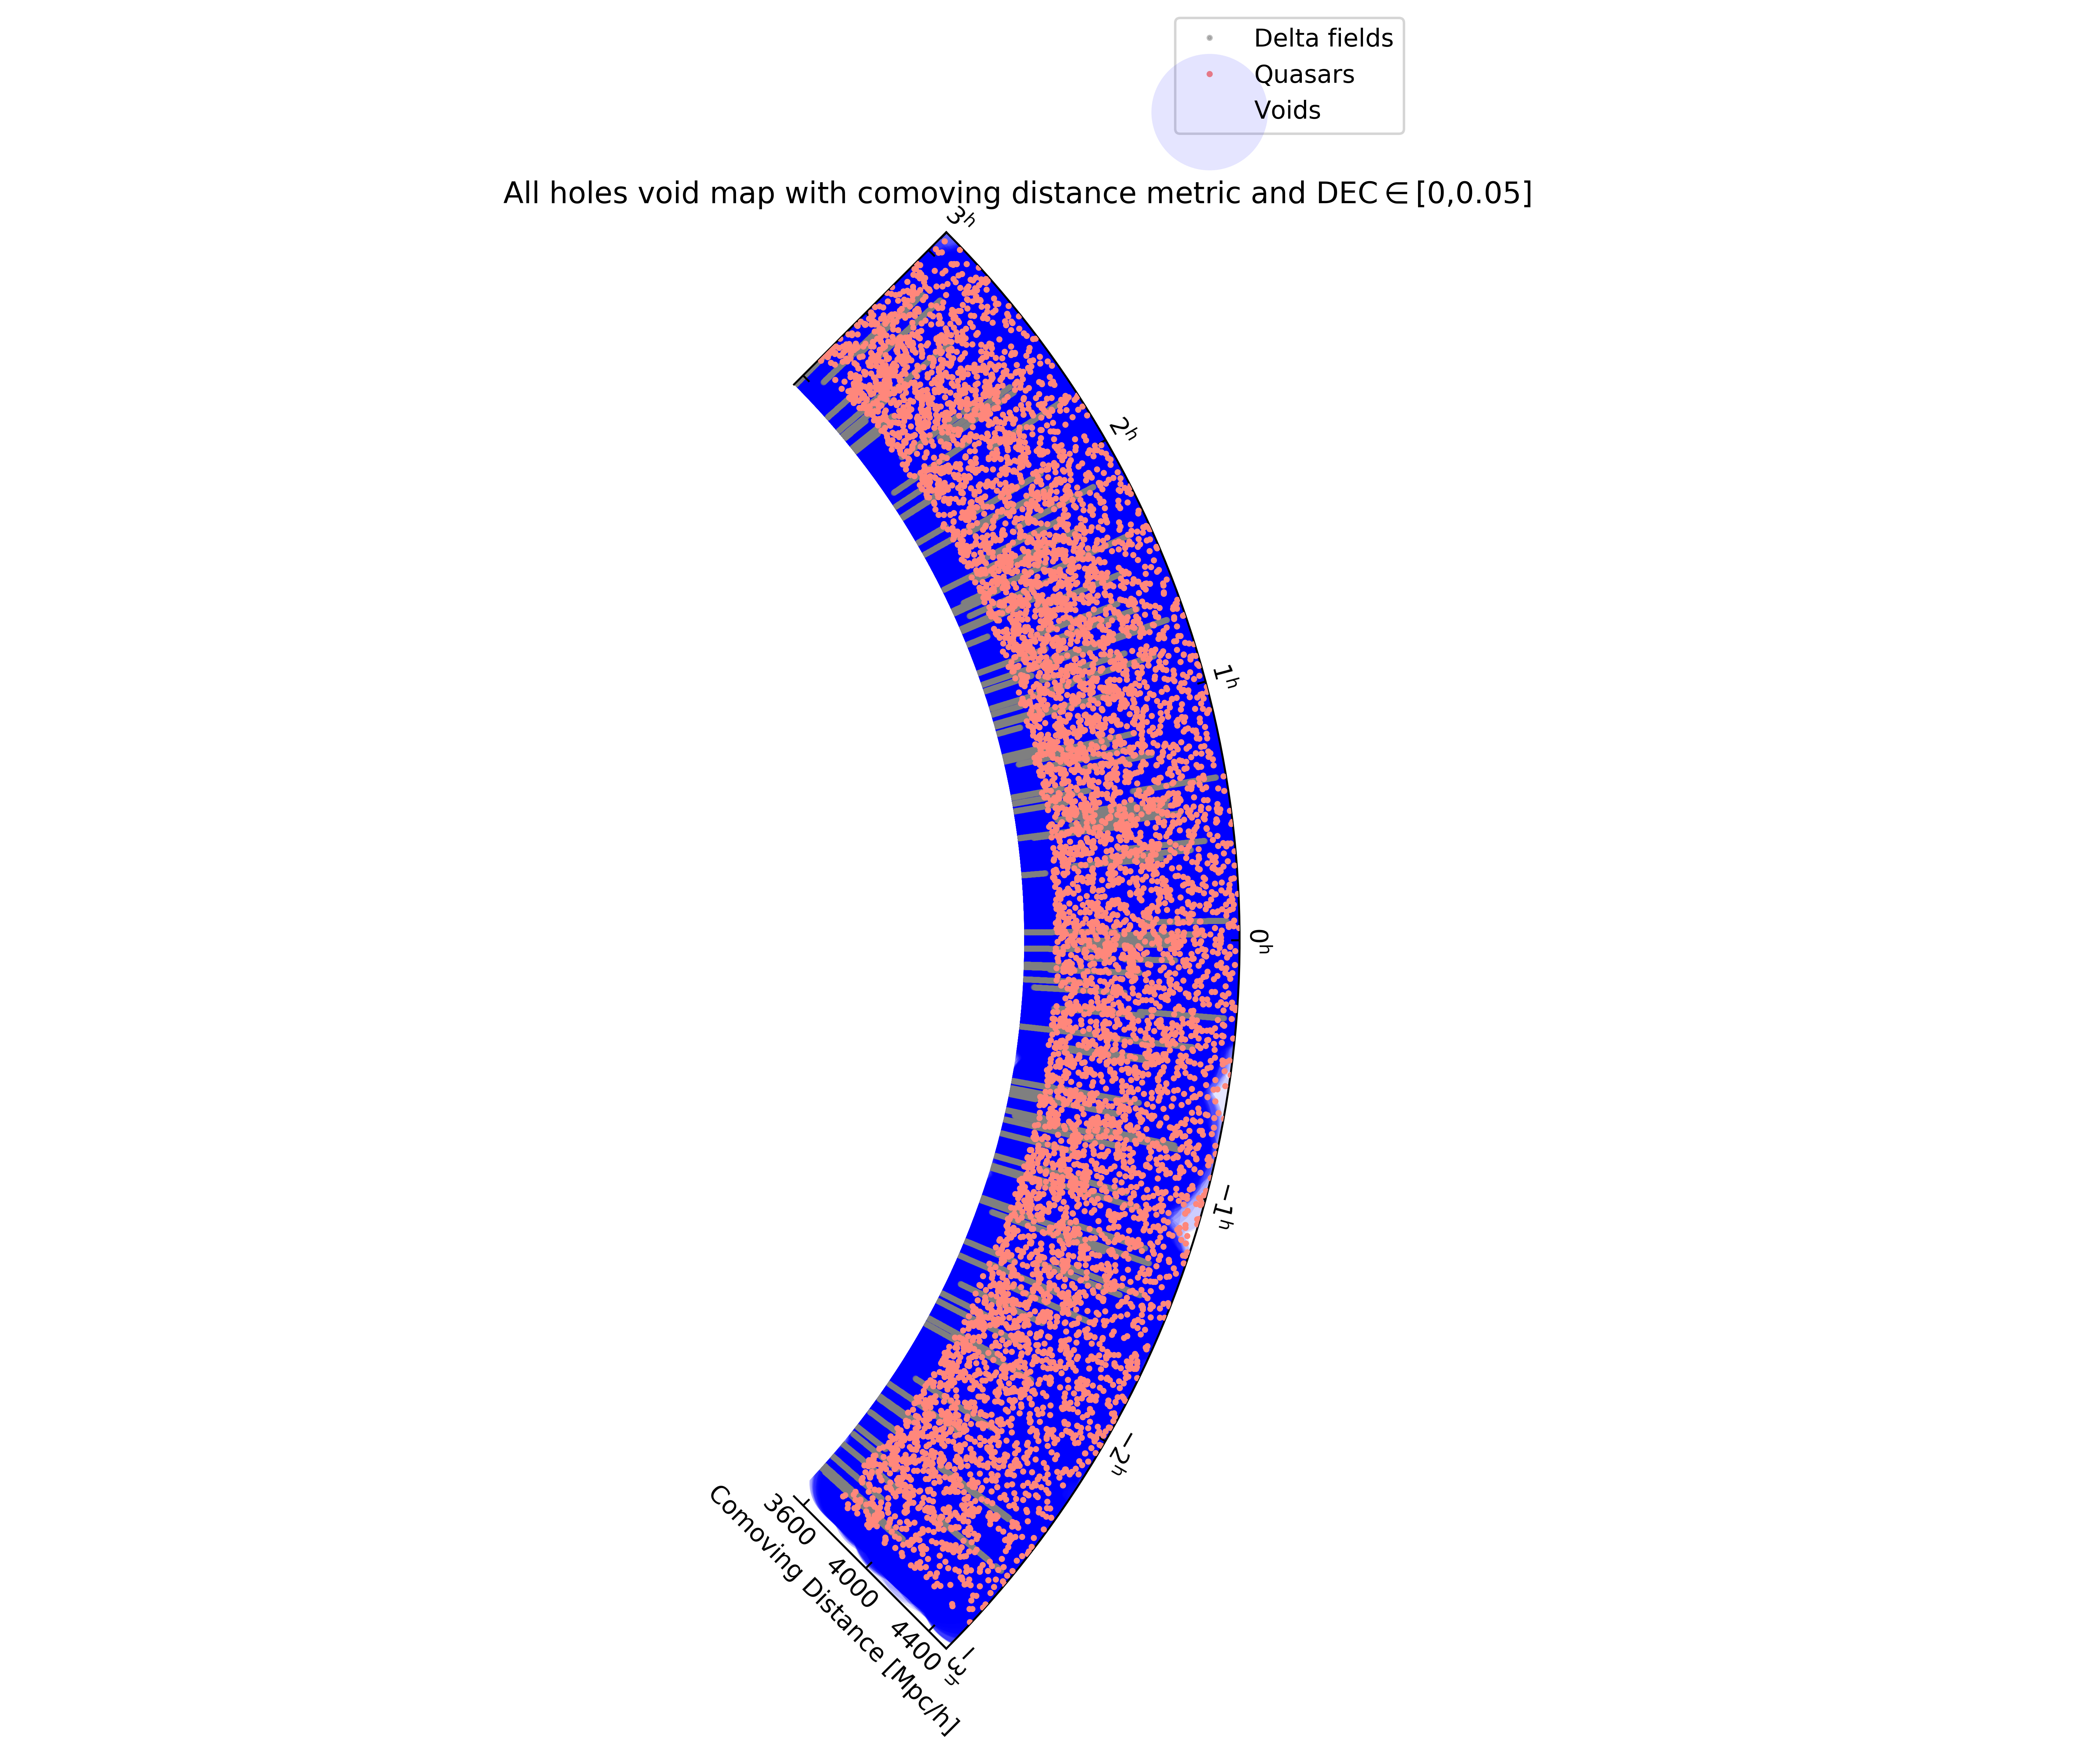

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,10))

# Range of ra to use in plot
ra_min, ra_max = -45, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars['ra'], 
            quasars['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -5, 5

fig = plt.figure(figsize=(15,10))

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars['ra'], 
            quasars['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

## Even thinner slice

In [ ]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get different slices
d,s = 0, 0.005 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small
slice_ = d + 0.5*s

In [ ]:
dr7_dec_cut = np.logical_and(dr7_galaxies['dec'] > d, 
                             dr7_galaxies['dec'] <= d + s)

#dr7LOWZ_dec_cut = np.logical_and(dr7LOWZ_galaxies['dec'] > d, 
#                                 dr7LOWZ_galaxies['dec'] <= d + s)
#
vollim_dr7_dec_cut = np.logical_and(vollim_dr7_galaxies['dec'] > d, 
                                    vollim_dr7_galaxies['dec'] <= d + s)
#
dr7_dec_slice = dr7_galaxies[dr7_dec_cut]
#dr7LOWZ_dec_slice = dr7LOWZ_galaxies[dr7LOWZ_dec_cut]
vollim_dr7_dec_slice = vollim_dr7_galaxies[vollim_dr7_dec_cut]

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                             quasars['dec'] <= d + s)

quasars_slice = quasars[quasars_dec_cut]

In [ ]:
cz_min, cz_max = min(dr7_galaxies['r']), max(quasars['r']) #32700

dr7_dist_boolean = np.logical_and(dr7_dec_slice['r'] > cz_min, 
                                  dr7_dec_slice['r'] <= cz_max)

#dr7LOWZ_dist_boolean = np.logical_and(dr7LOWZ_dec_slice['cz'] > cz_min, 
#                                      dr7LOWZ_dec_slice['cz'] <= cz_max)
#
#vollim_dr7_dist_boolean = np.logical_and(vollim_dr7_dec_slice['cz'] > cz_min, 
#                                         vollim_dr7_dec_slice['cz'] <= cz_max)
#
dr7_sample = dr7_dec_slice[dr7_dist_boolean]
#dr7LOWZ_sample = dr7LOWZ_dec_slice[dr7LOWZ_dist_boolean]
#vollim_dr7_sample = vollim_dr7_dec_slice[vollim_dr7_dist_boolean]


In [ ]:
dr7_dec_intersect_cut = np.sin(np.abs(slice_ - dr7_voids['dec'])*np.pi/180)*dr7_voids['r'] <= dr7_voids['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

dr7_void_sample = dr7_voids[dr7_dec_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
dr7_void_sample['radius_intersect'] = np.sqrt(dr7_void_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - dr7_void_sample['dec'])*np.pi/180)*dr7_void_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,10))

# Range of ra to use in plot
ra_min, ra_max = -45, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars['ra'], 
            quasars['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -15, 15

fig = plt.figure(figsize=(15,10))

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='Voids')

aux_ax.plot(quasars_slice['ra'], 
            quasars_slice['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

## Comparison with 10 Mpc/h

In [ ]:
dec10_intersect_cut = np.sin(np.abs(slice_ - voids10['dec'])*np.pi/180)*voids10['r'] <= voids10['radius']
#dr7LOWZ_dec_intersect_cut = np.sin(np.abs(slice_ - dr7LOWZ_voids['dec'])*np.pi/180)*dr7LOWZ_voids['r'] <= dr7LOWZ_voids['radius']

void10_sample = voids10[dec10_intersect_cut]
#dr7LOWZ_void_sample = dr7LOWZ_voids[dr7LOWZ_dec_intersect_cut]

# Radius of void at intersection
void10_sample['radius_intersect'] = np.sqrt(void10_sample['radius']**2 
                                              - (np.sin(np.abs(slice_ - void10_sample['dec'])*np.pi/180)*void10_sample['r'])**2)

#dr7LOWZ_void_sample['radius_intersect'] = np.sqrt(dr7LOWZ_void_sample['radius']**2 
#                                                  - (np.sin(np.abs(slice_ - dr7LOWZ_void_sample['dec'])*np.pi/180)*dr7LOWZ_void_sample['r'])**2)

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -15, 15

fig = plt.figure(figsize=(15,10))

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Original DR7 galaxies
aux_ax.plot(dr7_sample['ra'], dr7_sample['r'], 
            '.', c='grey', alpha=0.5, ms=3, zorder=2, label='Delta fields')

# Volume-limited DR7 galaxies
#aux_ax.plot(vollim_dr7_sample['ra'], vollim_dr7_sample['cz'], 
#            '.', c='g', zorder=2, label='Volume-limited DR7')

# Downsampled DR7 galaxies
#aux_ax.plot(dr7LOWZ_sample['ra'], dr7LOWZ_sample['cz'], 
#            '.', c='m', zorder=3, label='DR7 LOWZ')

# Original voids
aux_ax.scatter(void10_sample['ra'], void10_sample['r'], 
               s=void10_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='g', alpha=0.1, 
               zorder=1, label='min maximal radius=10.0 Mpc/h')

aux_ax.scatter(dr7_void_sample['ra'], dr7_void_sample['r'], 
               s=dr7_void_sample['radius_intersect']*100, 
               edgecolors='none', facecolors='b', alpha=0.1, 
               zorder=1, label='min maximal radius=20.0 Mpc/h')


aux_ax.plot(quasars_slice['ra'], 
            quasars_slice['r'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=3, label='Quasars')
# Downsampled voids
#aux_ax.scatter(dr7LOWZ_void_sample['ra'], dr7LOWZ_void_sample['r']*100, 
#               s=dr7LOWZ_void_sample['radius_intersect']*100, 
#               edgecolors='none', facecolors='tab:orange', alpha=0.1, 
#               zorder=5, label='DR7 LOWZ voids')

ax.legend(bbox_to_anchor=(1.1, 1.05),loc='lower center')

mpl.rc('font', size=10)
plt.title('All holes void map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
plt.tight_layout();

In [ ]:
len(void10_sample)

In [ ]:
len(voids10)

In [ ]:
len(dr7_void_sample)

In [ ]:
len(dr7_voids)

In [ ]:
#Histogram of redshift
dpi=500
mpl.rcParams['figure.dpi']= dpi

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for all void radii',fontsize=14)                                         
plt.xlabel(r'radius [Mpc/h]',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   

plt.hist(voids10['radius'] ,color='teal', label='min maximal radius=10.0 Mpc/h')
plt.hist(dr7_voids['radius'] ,color='slateblue', label='min maximal radius=20.0 Mpc/h')#,bins=range(20,50))#,bins=range(int(min(galaxies['cz'])), int(max(galaxies['cz'])) + 0.1, 0.1), color='teal')                                                                   \
#,bins=range(20,50))                                                                                                  
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')
plt.legend();
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')

In [ ]:
#Histogram of redshift
dpi=500
mpl.rcParams['figure.dpi']= dpi

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for distance to all voids',fontsize=14)                                         
plt.xlabel(r'r [Mpc/h]',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   
                                                                                                    
#,bins=range(int(min(galaxies['cz'])), int(max(galaxies['cz'])) + 0.1, 0.1), color='teal')                                                                   \
plt.hist(voids10['r'] ,color='teal', label='min maximal radius=10.0 Mpc/h')   
plt.hist(dr7_voids['r'] ,color='slateblue', label='min maximal radius=20.0 Mpc/h')
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')  
plt.legend();
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')